In [1]:
import pandas as pd
import os


def get_csv_data(video_folder_name, fileName):
    data = pd.read_csv(fileName, sep=';')
    data.columns = ['ID', 'file_name', 'cut_frame']
    file_paths = []
    for entry in data.iloc():
        file_paths.append(video_folder_name + entry['file_name'])
    data['file_path'] = file_paths
    return data


training = get_csv_data(
    '../WS2020_DeepLearning_Videos/Task2_Training_Validation/', '../Task2_Training.csv')
test = get_csv_data(
    '../WS2020_DeepLearning_Videos/Task2_Test/', '../Task2_Test.csv')

training.dropna(inplace=True)
test.dropna(inplace=True)

display(training)
display(test)

,ID,file_name,cut_frame,file_path
0,1,_8Vy3dlHg2w_00132.mp4,63.0,../WS2020_DeepLearning_Videos/Task2_Training_V...
1,2,_8Vy3dlHg2w_00133.mp4,25.0,../WS2020_DeepLearning_Videos/Task2_Training_V...
2,3,_8Vy3dlHg2w_00136.mp4,71.0,../WS2020_DeepLearning_Videos/Task2_Training_V...
3,4,_8Vy3dlHg2w_00139.mp4,35.0,../WS2020_DeepLearning_Videos/Task2_Training_V...
4,5,_8Vy3dlHg2w_00142.mp4,20.0,../WS2020_DeepLearning_Videos/Task2_Training_V...
...,...,...,...,...
295,296,_tigfCJFLZg_00285.mp4,51.0,../WS2020_DeepLearning_Videos/Task2_Training_V...
296,297,_tigfCJFLZg_00286.mp4,130.0,../WS2020_DeepLearning_Videos/Task2_Training_V...
297,298,_tigfCJFLZg_00289.mp4,52.0,../WS2020_DeepLearning_Videos/Task2_Training_V...
298,299,_tigfCJFLZg_00290.mp4,122.0,../WS2020_DeepLearning_Videos/Task2_Training_V...


,ID,file_name,cut_frame,file_path
0,1,_tigfCJFLZg_00293.mp4,131.0,../WS2020_DeepLearning_Videos/Task2_Test/_tigf...
1,2,_tigfCJFLZg_00295.mp4,85.0,../WS2020_DeepLearning_Videos/Task2_Test/_tigf...
2,3,_tigfCJFLZg_00298.mp4,93.0,../WS2020_DeepLearning_Videos/Task2_Test/_tigf...
3,4,_tigfCJFLZg_00299.mp4,138.0,../WS2020_DeepLearning_Videos/Task2_Test/_tigf...
4,5,_tigfCJFLZg_00301.mp4,124.0,../WS2020_DeepLearning_Videos/Task2_Test/_tigf...
...,...,...,...,...
85,86,_tigfCJFLZg_00428.mp4,45.0,../WS2020_DeepLearning_Videos/Task2_Test/_tigf...
86,87,_tigfCJFLZg_00429.mp4,125.0,../WS2020_DeepLearning_Videos/Task2_Test/_tigf...
87,88,_tigfCJFLZg_00430.mp4,49.0,../WS2020_DeepLearning_Videos/Task2_Test/_tigf...
90,91,_tigfCJFLZg_00435.mp4,44.0,../WS2020_DeepLearning_Videos/Task2_Test/_tigf...


## Build data

### General build properties

In [9]:
# Build properties #
# You can use those properties to control the build proces #
# ---------------------------------------------------------#

class_names = ['wet', 'dry']

augmentations = ['flip']
size = (64, 64)
use_standardization = False
drop_problematic = True

### Build process

In [10]:
from data_fns import drop_problematic_videos, get_frames_labels
clean_training = training
clean_test = test
if drop_problematic:
    clean_training, clean_test = drop_problematic_videos(training, test)
training_frames, training_labels, augmented_training_frames, augmented_training_labels = get_frames_labels(
    clean_training, augmentations, size, use_standardization)
test_frames, test_labels, augmented_test_frames, augmented_test_labels = get_frames_labels(
    clean_test, augmentations, size, use_standardization)

(299, 4)
(87, 4)


In [11]:
from data_fns import build_data
data = build_data(
    training={
        "frames": training_frames,
        "labels": training_labels,
        "augmented_frames": augmented_training_frames,
        "augmented_labels": augmented_training_labels
    },
    test={
        "frames": test_frames,
        "labels": test_labels,
        "augmented_frames": augmented_test_frames,
        "augmented_labels": augmented_test_labels
    },
    validation_split=0.33
)
x_train = data["training"]["x"]
y_train = data["training"]["y"]
x_validation = data["training"]["x_validation"]
y_validation = data["training"]["y_validation"]
all_test_frames = data["test"]["x"]
all_test_labels = data["test"]["y"]

Basic Training frames: 24724
Augmented Training frames: 24724
Training frames: 49448
Basic Test frames: 9683
Augmented Test frames: 9683
Test frames: 19366
Final training frames: 33130
Final validation frames: 16318


### Display example pictures

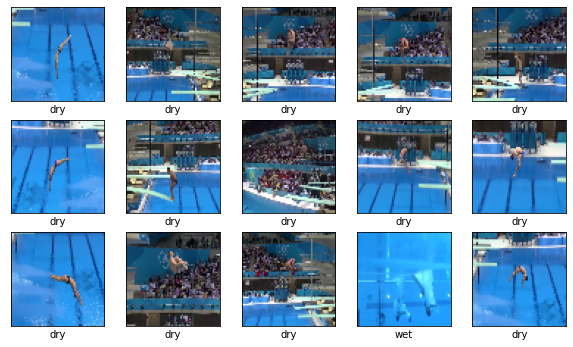

In [12]:
from img_fns import show_images

first_image = 50
last_image = 65
images = x_train
labels = y_train

show_images(first_image, last_image, images, labels, class_names)

### CNN Modeling Building

In [13]:
# This was an attempt to make the model reproducible. Those expressions try to fixate all randomness variables used by TensorFlow and it's ecosystem.
# As of now, the attempt failed.

# # Set a seed value
# seed_value= 12321 
# # 1. Set `PYTHONHASHSEED` environment variable at a fixed value
# import os
# os.environ['PYTHONHASHSEED'] = str(seed_value)
# # 2. Set `python` built-in pseudo-random generator at a fixed value
# import random
# random.seed(seed_value)
# # 3. Set `numpy` pseudo-random generator at a fixed value
# import numpy as np
# np.random.seed(seed_value)
# # 4. Set `tensorflow` pseudo-random generator at a fixed value
# import tensorflow as tf
# tf.random.set_seed(seed_value)
# # # 5. Configure a new global `tensorflow` session
# # from keras import backend as K
# # session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
# # sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
# # K.set_session(sess)

# session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
# sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
# tf.compat.v1.keras.backend.set_session(sess)

In [14]:
from model_fns import build_model, train_model
size1, size2 = size
model = build_model(input_shape = (size1, size2, 3))
model.summary()
history = train_model(model, x_train, y_train, x_validation, y_validation)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
flatten_1 (Flatten)          (None, 53824)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                3444800   
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 130       
Total params: 3,464,322
Trainable params: 3,464,322
Non-trainable params: 0
____________________________________________

### Model Evaluation

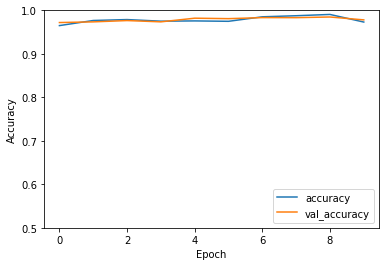

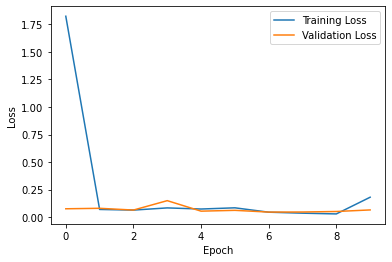

606/606 - 2s - loss: 0.0937 - accuracy: 0.9700
Test Accuracy: 0.9699989557266235, Test Loss: 0.09368780255317688


In [15]:
from model_fns import evaluate_model

evaluate_model(history, model, all_test_frames, all_test_labels)